# Zero Crossing - in frequency domain.

Zero Crossing is a great technique to process sound fast and to store it in a compact way,
but there are some limitations. This is an attempt to do something similar with FFT (...yes I know, I'm not the first one...).

Basic ideas:

- Keep it fast by using time domain techniques to determine where to run FFT.
- Add support for multiple harmonics and dBFS.
- Try to dynamically adjust to noise level.
- Extract metrics suitable to visualise in a scatter plot.
- Think of bat sound as "sparse data", not "densed data".


In [1]:
# For inline plotting.
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 4)

In [2]:
# Math and sound processing.
import numpy as np
import librosa
import librosa.display

In [3]:
# Plotting for later use on the web.
from bokeh.io import output_notebook
from bokeh.plotting import output_file, show, figure
from bokeh.charts import Scatter
from bokeh.models import Range1d, HoverTool
# Load BokehJS.
output_notebook()
# Open plot in new tab.
output_file("zero_crossing_in_frequency_domain.html")

Loading BokehJS ...

In [4]:
# Settings.
sound_file = '../data_in/Mdau_TE384.wav'
#sound_file = '../data_in/Ppip_TE384.wav'
#sound_file = '../data_in/Myotis-Plecotus-Eptesicus_TE384.wav'

cutoff_freq_hz = 15000

In [5]:
# Load sound file.
signal, sr = librosa.load(sound_file, sr=None)

In [6]:
# Check if TE, Time Expansion.
sampling_freq = sr
if '_TE' in sound_file:
    sampling_freq *= 10
# Sound file info.
print('Sampling freq in file (after TE): ' + str(sr) + ' Hz.')
print('Original sampling freq: ' + str(sampling_freq) + ' Hz.')
print(str(len(signal)) + ' samples.')
print('Original rec. length: ' + str(len(signal) / sr / 10) + ' sec.')

Sampling freq in file (after TE): 38400 Hz.
Original sampling freq: 384000 Hz.
398012 samples.
Original rec. length: 1.0364895833333334 sec.


In [7]:
# Noise level. RMS, root-mean-square. Calculated for the whole file.
# (May be calculated over buffers later since weather etc. changes over time.)
noise_level = np.sqrt(np.mean(np.square(signal)))

noise_level_dbfs = 20 * np.log10(np.abs(noise_level) / 1.0)

print('Noise: ' + str(noise_level) + ' noise-dbfs: ' + str(noise_level_dbfs))

Noise: 0.0303963 noise-dbfs: -30.3435745399


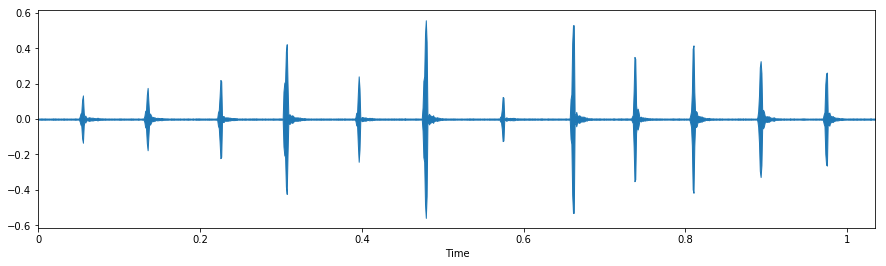

In [8]:
# Plot. Time is real time.
librosa.display.waveplot(signal, sr=sampling_freq)
plt.show()

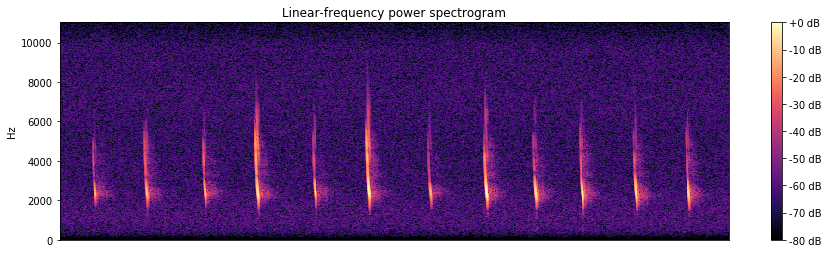

In [9]:
# Plot spectrogram. Note: Wrong Hz due to librosas default sr at 22050.
D = librosa.amplitude_to_db(librosa.stft(signal), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.show()

In [10]:
# Find peaks in time domain (rmse and localmax).
def find_peaks(y, hop_length):
    # Set all to zero in the noisy part.
    y2 = y.copy()
    rms_tot = np.sqrt(np.mean(np.square(y)))
    y2[(np.abs(y2) < (rms_tot * 1.5))] = 0.0
    # Calculate rmse over 1024 samples and move 1 ms forvard each time.
    rmse = librosa.feature.rmse(y=y2, hop_length=384, frame_length=1024, center=True)
    # Find local max in the rmse array.
    locmax = librosa.util.localmax(rmse.T)
    # From true/false array to index list.
    maxindexlist = []
    for index, a in enumerate(locmax):
        if a: maxindexlist.append(index)
    # Convert indexlist to match original signal.
    index_list = librosa.frames_to_samples(maxindexlist, hop_length=hop_length)
    return index_list

In [11]:
%%timeit
peaks = find_peaks(signal, hop_length=384)

100 loops, best of 3: 4.92 ms per loop


In [12]:
peaks = find_peaks(signal, hop_length=384)

In [13]:
print(len(peaks))
peaks

13


array([ 21120,  51840,  85248,  86784, 117888, 152064, 183936, 220800,
       253824, 283392, 311040, 342912, 374400])

In [14]:
# Convert frame to dBFS spectrum.
def calc_dbfs_spectrum(frame, window_function, dbfs_max):
    #print(len(signal))
    frame = frame * window_function
    spectrum = np.fft.rfft(frame)
    dbfs_spectrum = 20 * np.log10(np.abs(spectrum) / dbfs_max)
    return dbfs_spectrum

In [15]:
# Static values calculated for a specific window size.
window_size = 256
half_window = int(window_size / 2)
hamming_window = np.hamming(window_size)
hamming_dbfs_max = np.sum(hamming_window) / 2 # Max db value in window. DBFS = db full scale. Half spectrum used.
# Used as y array in kHz
self_freq_bins_hz = np.arange((window_size / 2) + 1) / (window_size / sampling_freq)

In [16]:
# Test
index = peaks[8]
dbfs_spectrum = calc_dbfs_spectrum(signal[index-half_window:index+half_window], 
                                   hamming_window, hamming_dbfs_max)
dbmax=np.max(dbfs_spectrum)
dbmax

-8.6344559166930761

In [17]:
%%timeit
for index in peaks:
    dbfs_spectrum = calc_dbfs_spectrum(signal[index-half_window:index+half_window], 
                                       hamming_window, hamming_dbfs_max)

1000 loops, best of 3: 519 µs per loop


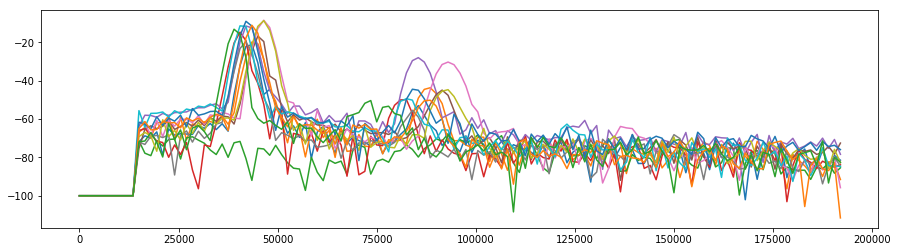

In [18]:
# Plot dBFS over frequency (Hz).
for index in peaks:
    dbfs_spectrum = calc_dbfs_spectrum(signal[index-half_window:index+half_window], 
                                       hamming_window, hamming_dbfs_max)
    # Cut off low frequencies.
    dbfs_spectrum[(self_freq_bins_hz < cutoff_freq_hz)] = -100.0
    plt.plot(self_freq_bins_hz, dbfs_spectrum)
plt.show()

In [19]:
# List peak and dBFS.
for index in peaks:
    dbfs_spectrum = calc_dbfs_spectrum(signal[index-half_window:index+half_window], 
                                       hamming_window, hamming_dbfs_max)
    # Cut off low frequencies.
    dbfs_spectrum[(self_freq_bins_hz < cutoff_freq_hz)] = -100.0
    # Find max.
    bin_peak_index = dbfs_spectrum.argmax()
    peak_frequency_hz = bin_peak_index * sampling_freq / window_size
    time = index / sampling_freq
    db_peak = np.max(dbfs_spectrum)
    print('Time: ' + str(time) + '  Freq.: ' + str(peak_frequency_hz) + '  dBFS peak: ' + str(db_peak))

Time: 0.055  Freq.: 43500.0  dBFS peak: -21.1402337157
Time: 0.135  Freq.: 43500.0  dBFS peak: -19.8070455847
Time: 0.222  Freq.: 93000.0  dBFS peak: -67.6142410583
Time: 0.226  Freq.: 40500.0  dBFS peak: -14.6223831639
Time: 0.307  Freq.: 42000.0  dBFS peak: -11.4497904122
Time: 0.396  Freq.: 45000.0  dBFS peak: -16.7063135813
Time: 0.479  Freq.: 46500.0  dBFS peak: -8.43160140727
Time: 0.575  Freq.: 42000.0  dBFS peak: -19.5042625759
Time: 0.661  Freq.: 46500.0  dBFS peak: -8.63445591669
Time: 0.738  Freq.: 40500.0  dBFS peak: -11.354199546
Time: 0.81  Freq.: 42000.0  dBFS peak: -8.9824376288
Time: 0.893  Freq.: 43500.0  dBFS peak: -11.0389371891
Time: 0.975  Freq.: 39000.0  dBFS peak: -13.1188019522


In [20]:
# Test.
(noise_level_dbfs / 1.5)

-20.22904969325505

db_peak: -38.8330846477   db_mean: -74.3715517584   threshold_db: -63.7100116252
Number of peaks: 2
db_peak: -38.4145615934   db_mean: -73.5056277141   threshold_db: -62.9783078779
Number of peaks: 3
db_peak: -70.7200101853   db_mean: -80.7936614857   threshold_db: -77.7715660955
Skipped. Peak level too low.
db_peak: -35.3762845609   db_mean: -76.5550556468   threshold_db: -64.201424321
Number of peaks: 3
db_peak: -31.5676869874   db_mean: -65.3748096993   threshold_db: -55.2326728857
Number of peaks: 2
db_peak: -37.5299253796   db_mean: -70.6883310112   threshold_db: -60.7408093217
Number of peaks: 2
db_peak: -29.356781521   db_mean: -69.9019715336   threshold_db: -57.7384145298
Number of peaks: 2
db_peak: -38.6761592772   db_mean: -75.8421062308   threshold_db: -64.6923221447
Number of peaks: 1
db_peak: -29.6232896665   db_mean: -71.3641372881   threshold_db: -58.8418830016
Number of peaks: 2
db_peak: -34.8106380286   db_mean: -70.7167199617   threshold_db: -59.9448953818
Number of p

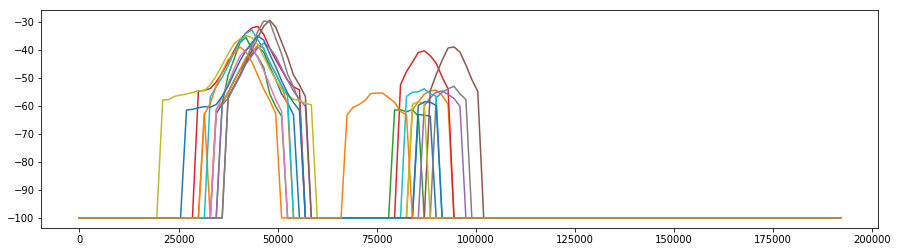

In [21]:
for index in peaks: # [peaks[5]]: # peaks:
    dbfs_spectrum = calc_dbfs_spectrum(signal[index-half_window:index+half_window], 
                                       hamming_window, hamming_dbfs_max)
    # Cut off low frequencies.    
    dbfs_spectrum[(self_freq_bins_hz < cutoff_freq_hz)] = -100.0
    # Smoothing. Mean over frame_length.
    rmse = librosa.feature.rmse(y=dbfs_spectrum, hop_length=1, frame_length=8, center=True)
    dbfs_spectrum = - rmse[0]
    #print(dbfs_spectrum)
    
    db_peak = np.max(dbfs_spectrum)
    db_mean = np.mean(dbfs_spectrum)
    threshold_db = db_mean - (db_mean - db_peak) * 0.3
    print('db_peak: ' + str(db_peak) + '   db_mean: ' + str(db_mean) + '   threshold_db: ' + str(threshold_db))
    if db_peak > (db_mean / 1.2):
#    if db_peak > (noise_level_dbfs / 1.2):
        dbfs_spectrum[(dbfs_spectrum < threshold_db)] = -100.0
        plt.plot(self_freq_bins_hz, dbfs_spectrum[:-1])
        locmax = librosa.util.localmax(dbfs_spectrum)
        max_index_list = []
        for index, a in enumerate(locmax):
            if a: max_index_list.append(index)
        print('Number of peaks: ' + str(len(max_index_list)))
    else:
        print('Skipped. Peak level too low.')
        
plt.show()    

# To be continued...